Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [ ]:
# normal data
X_test, y_test, _, X_train_valid, y_train_valid, _ = import_data()


# DeepConv, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.0632], Training accuracy [55.22%]
Epoch [10], Validation loss [1.2314], Validation accuracy [42.88%]
Epoch [20], Training loss [0.8644], Training accuracy [65.43%]
Epoch [20], Validation loss [1.0104], Validation accuracy [58.01%]
Epoch [30], Training loss [0.7671], Training accuracy [69.98%]
Epoch [30], Validation loss [0.9496], Validation accuracy [61.42%]
Epoch [40], Training loss [0.6781], Training accuracy [73.79%]
Epoch [40], Validation loss [0.8817], Validation accuracy [64.78%]
Epoch [50], Training loss [0.6086], Training accuracy [76.79%]
Epoch [50], Validation loss [0.8617], Validation accuracy [65.74%]
Epoch [60], Training loss [0.5527], Training accuracy [79.24%]
Epoch [60], Validation loss [0.8611], Validation accuracy [66.22%]
Epoch [70], Training loss [0.4959], Training accuracy [81.68%]
Epoch [70], Validation loss [0.8315], Validation accuracy [68.39%]
Epoch [80], Training loss [0.4471], Training accuracy [82.98%]
Epoch [80]

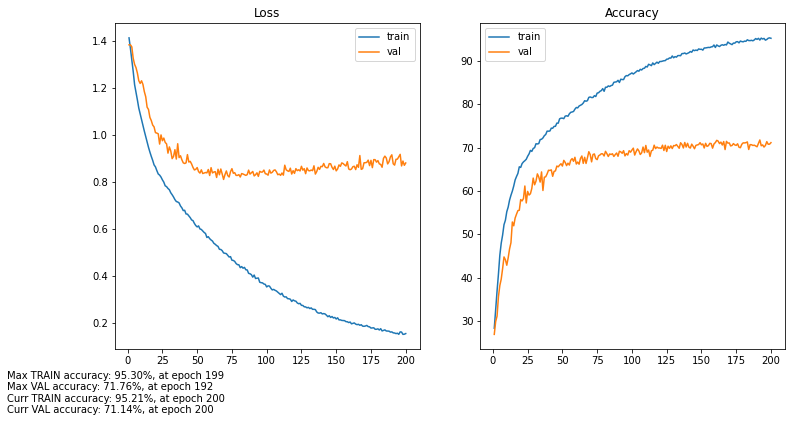

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))



# DeepConv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.0680], Training accuracy [54.86%]
Epoch [10], Validation loss [1.2031], Validation accuracy [49.07%]
Epoch [20], Training loss [0.8041], Training accuracy [68.89%]
Epoch [20], Validation loss [1.1096], Validation accuracy [56.09%]
Epoch [30], Training loss [0.6883], Training accuracy [73.41%]
Epoch [30], Validation loss [1.1090], Validation accuracy [57.47%]
Epoch [40], Training loss [0.6060], Training accuracy [77.08%]
Epoch [40], Validation loss [1.0636], Validation accuracy [60.99%]
Epoch [50], Training loss [0.5247], Training accuracy [80.18%]
Epoch [50], Validation loss [1.0412], Validation accuracy [62.58%]
Epoch [60], Training loss [0.4649], Training accuracy [82.53%]
Epoch [60], Validation loss [1.0592], Validation accuracy [62.97%]
Epoch [70], Training loss [0.4110], Training accuracy [84.69%]
Epoch [70], Validation loss [1.0611], Validation accuracy [63.38%]
Epoch [80], Training loss [0.3663], Training accuracy [86.43%]
Epoch [80]

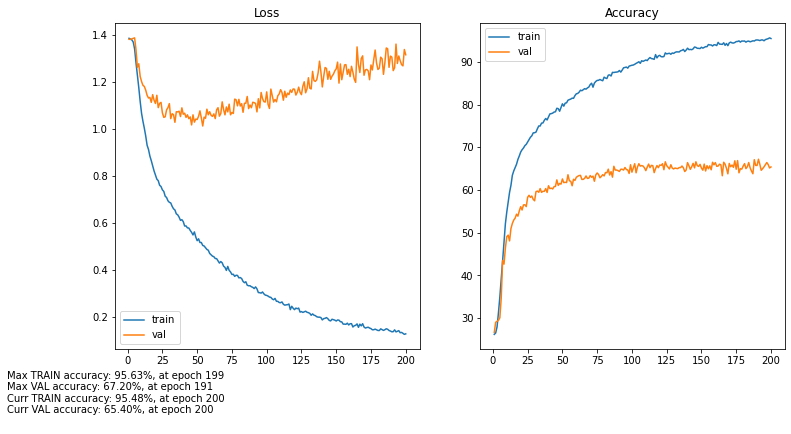

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv1, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.1200], Training accuracy [51.12%]
Epoch [10], Validation loss [1.1905], Validation accuracy [45.82%]
Epoch [20], Training loss [0.8590], Training accuracy [65.54%]
Epoch [20], Validation loss [1.0222], Validation accuracy [58.26%]
Epoch [30], Training loss [0.6826], Training accuracy [73.16%]
Epoch [30], Validation loss [0.9116], Validation accuracy [63.94%]
Epoch [40], Training loss [0.5468], Training accuracy [78.85%]
Epoch [40], Validation loss [0.9202], Validation accuracy [64.43%]
Epoch [50], Training loss [0.4472], Training accuracy [83.02%]
Epoch [50], Validation loss [0.8835], Validation accuracy [66.32%]
Epoch [60], Training loss [0.3474], Training accuracy [87.08%]
Epoch [60], Validation loss [0.8902], Validation accuracy [67.03%]
Epoch [70], Training loss [0.2758], Training accuracy [89.93%]
Epoch [70], Validation loss [0.8932], Validation accuracy [68.28%]
Epoch [80], Training loss [0.2262], Training accuracy [92.01%]
Epoch [80]

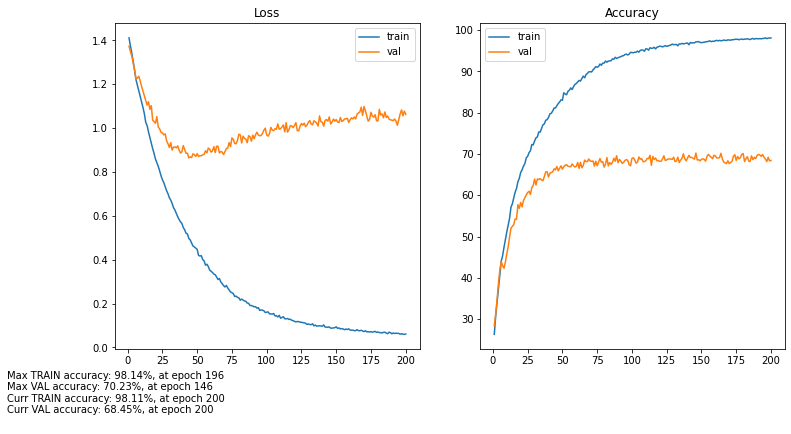

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3050], Training accuracy [36.54%]
Epoch [10], Validation loss [1.3495], Validation accuracy [30.80%]
Epoch [20], Training loss [1.1087], Training accuracy [51.12%]
Epoch [20], Validation loss [1.1356], Validation accuracy [45.97%]
Epoch [30], Training loss [0.9575], Training accuracy [59.72%]
Epoch [30], Validation loss [1.0122], Validation accuracy [56.20%]
Epoch [40], Training loss [0.8572], Training accuracy [64.86%]
Epoch [40], Validation loss [0.9173], Validation accuracy [62.58%]
Epoch [50], Training loss [0.7586], Training accuracy [69.36%]
Epoch [50], Validation loss [0.8499], Validation accuracy [66.34%]
Epoch [60], Training loss [0.6754], Training accuracy [73.68%]
Epoch [60], Validation loss [0.7471], Validation accuracy [71.98%]
Epoch [70], Training loss [0.6053], Training accuracy [76.75%]
Epoch [70], Validation loss [0.7184], Validation accuracy [72.60%]
Epoch [80], Training loss [0.5529], Training accuracy [78.70%]
Epoch [80]

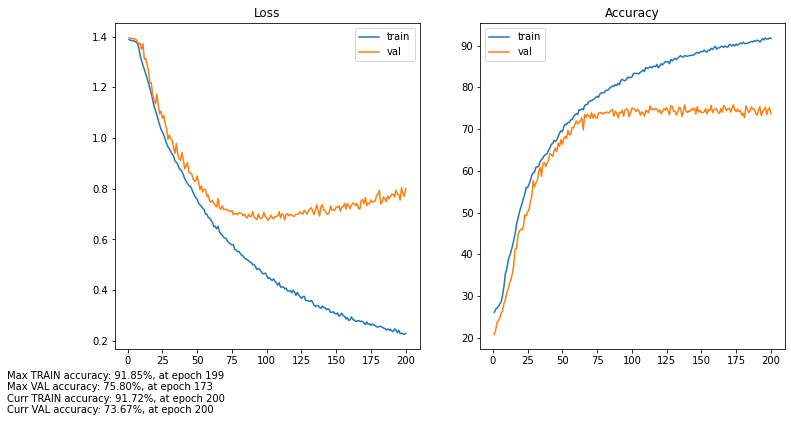

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv, no crop, base case

-- Fold [1/5] --
Epoch [10], Training loss [1.2829], Training accuracy [39.60%]
Epoch [10], Validation loss [1.3879], Validation accuracy [32.15%]
Epoch [20], Training loss [1.1049], Training accuracy [51.71%]
Epoch [20], Validation loss [1.2295], Validation accuracy [42.55%]
Epoch [30], Training loss [0.9978], Training accuracy [58.22%]
Epoch [30], Validation loss [1.1809], Validation accuracy [47.04%]
Epoch [40], Training loss [0.9221], Training accuracy [62.65%]
Epoch [40], Validation loss [1.1035], Validation accuracy [52.25%]
Epoch [50], Training loss [0.8409], Training accuracy [66.13%]
Epoch [50], Validation loss [1.0530], Validation accuracy [58.16%]
Epoch [60], Training loss [0.7869], Training accuracy [68.14%]
Epoch [60], Validation loss [0.9493], Validation accuracy [60.52%]
Epoch [70], Training loss [0.7516], Training accuracy [70.51%]
Epoch [70], Validation loss [0.9351], Validation accuracy [61.23%]
Epoch [80], Training loss [0.6742], Training accuracy [74.17%]
Epoch [80]

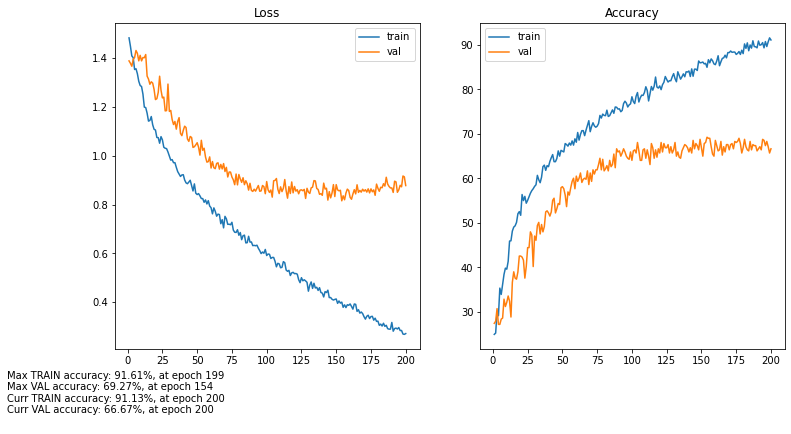

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))



# DeepConv2, no crop, base case

-- Fold [1/5] --
Epoch [10], Training loss [1.3379], Training accuracy [36.05%]
Epoch [10], Validation loss [1.3548], Validation accuracy [30.50%]
Epoch [20], Training loss [1.1978], Training accuracy [44.74%]
Epoch [20], Validation loss [1.2626], Validation accuracy [38.30%]
Epoch [30], Training loss [1.1312], Training accuracy [49.70%]
Epoch [30], Validation loss [1.2306], Validation accuracy [43.26%]
Epoch [40], Training loss [1.0611], Training accuracy [54.37%]
Epoch [40], Validation loss [1.1839], Validation accuracy [47.99%]
Epoch [50], Training loss [0.9963], Training accuracy [59.22%]
Epoch [50], Validation loss [1.1070], Validation accuracy [54.61%]
Epoch [60], Training loss [0.9250], Training accuracy [63.24%]
Epoch [60], Validation loss [1.0659], Validation accuracy [58.16%]
Epoch [70], Training loss [0.8953], Training accuracy [64.48%]
Epoch [70], Validation loss [1.0534], Validation accuracy [58.63%]
Epoch [80], Training loss [0.8579], Training accuracy [65.78%]
Epoch [80]

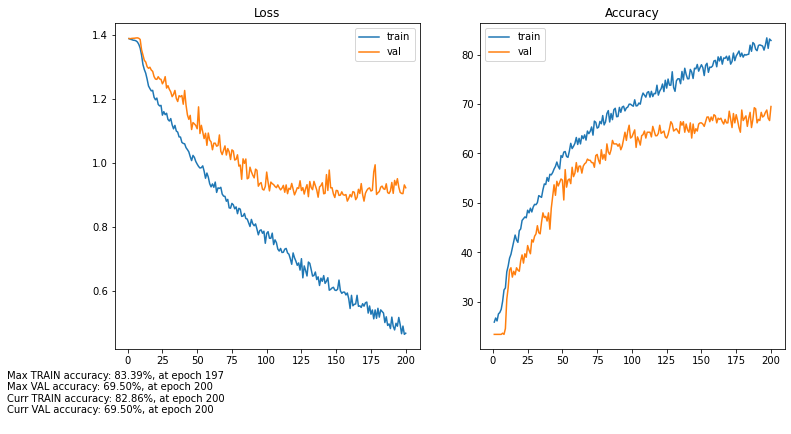

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv1, no crop, base case

-- Fold [1/5] --
Epoch [10], Training loss [1.2847], Training accuracy [39.07%]
Epoch [10], Validation loss [1.3361], Validation accuracy [36.64%]
Epoch [20], Training loss [1.1336], Training accuracy [50.53%]
Epoch [20], Validation loss [1.2242], Validation accuracy [44.21%]
Epoch [30], Training loss [1.0212], Training accuracy [56.68%]
Epoch [30], Validation loss [1.1545], Validation accuracy [49.88%]
Epoch [40], Training loss [0.9024], Training accuracy [62.65%]
Epoch [40], Validation loss [1.0836], Validation accuracy [53.90%]
Epoch [50], Training loss [0.8349], Training accuracy [66.55%]
Epoch [50], Validation loss [1.0514], Validation accuracy [56.26%]
Epoch [60], Training loss [0.7293], Training accuracy [71.10%]
Epoch [60], Validation loss [1.0147], Validation accuracy [59.10%]
Epoch [70], Training loss [0.6624], Training accuracy [74.29%]
Epoch [70], Validation loss [1.0268], Validation accuracy [56.97%]
Epoch [80], Training loss [0.5947], Training accuracy [76.00%]
Epoch [80]

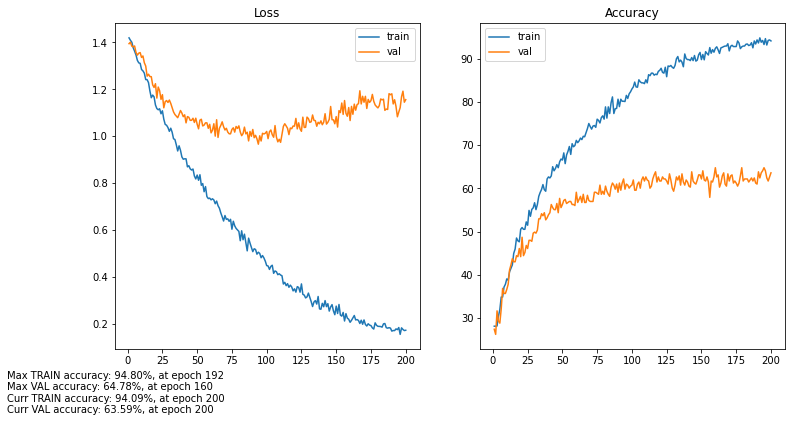

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, no crop, base case

-- Fold [1/5] --
Epoch [10], Training loss [1.3843], Training accuracy [27.01%]
Epoch [10], Validation loss [1.3827], Validation accuracy [27.42%]
Epoch [20], Training loss [1.3731], Training accuracy [29.85%]
Epoch [20], Validation loss [1.3645], Validation accuracy [31.44%]
Epoch [30], Training loss [1.3404], Training accuracy [32.62%]
Epoch [30], Validation loss [1.3337], Validation accuracy [34.99%]
Epoch [40], Training loss [1.3086], Training accuracy [35.05%]
Epoch [40], Validation loss [1.3521], Validation accuracy [33.81%]
Epoch [50], Training loss [1.2706], Training accuracy [38.48%]
Epoch [50], Validation loss [1.3399], Validation accuracy [35.46%]
Epoch [60], Training loss [1.2441], Training accuracy [40.31%]
Epoch [60], Validation loss [1.3532], Validation accuracy [38.77%]
Epoch [70], Training loss [1.2155], Training accuracy [44.03%]
Epoch [70], Validation loss [1.3215], Validation accuracy [39.01%]
Epoch [80], Training loss [1.1889], Training accuracy [43.68%]
Epoch [80]

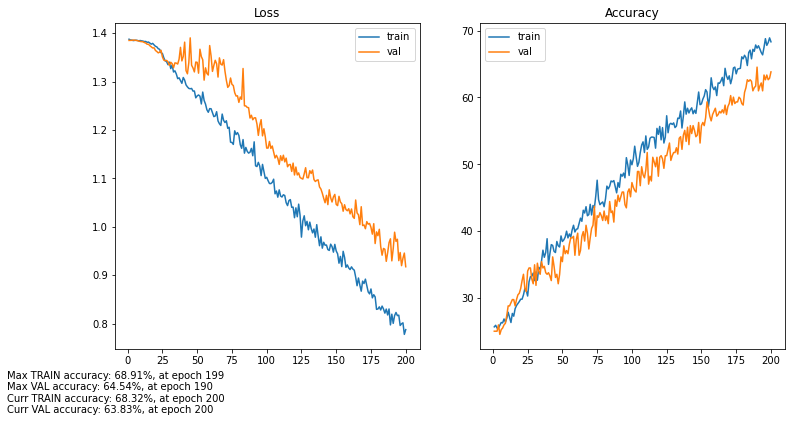

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, no crop, base case, longer epochs, (just curious)

-- Fold [1/5] --
Epoch [10], Training loss [1.3840], Training accuracy [27.19%]
Epoch [10], Validation loss [1.3833], Validation accuracy [26.00%]
Epoch [20], Training loss [1.3744], Training accuracy [29.31%]
Epoch [20], Validation loss [1.3673], Validation accuracy [31.68%]
Epoch [30], Training loss [1.3325], Training accuracy [34.52%]
Epoch [30], Validation loss [1.3300], Validation accuracy [33.81%]
Epoch [40], Training loss [1.2968], Training accuracy [38.24%]
Epoch [40], Validation loss [1.3260], Validation accuracy [34.52%]
Epoch [50], Training loss [1.2655], Training accuracy [39.24%]
Epoch [50], Validation loss [1.2924], Validation accuracy [35.46%]
Epoch [60], Training loss [1.2537], Training accuracy [39.66%]
Epoch [60], Validation loss [1.3100], Validation accuracy [34.99%]
Epoch [70], Training loss [1.1949], Training accuracy [45.63%]
Epoch [70], Validation loss [1.2335], Validation accuracy [39.72%]
Epoch [80], Training loss [1.1350], Training accuracy [48.76%]
Epoch [80]

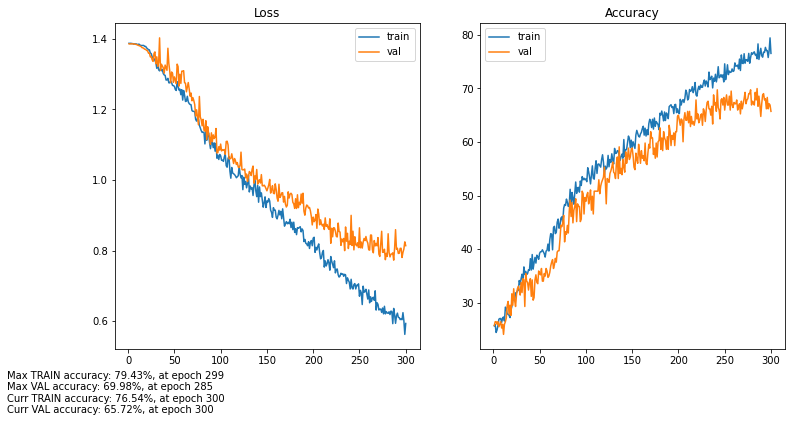

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 300

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))